In [1]:
import numpy as np
import pandas as pd
#import pymc as pm
#from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [35]:
exp=np.genfromtxt("expdata.txt", delimiter='\t')
amp0=np.genfromtxt("amp0.txt", delimiter='\t')
iptg=exp[:,0][:,None]
tet0=exp[:,1][:,None]
MIC_exp=exp[:,2][:,None]
IND_exp=exp[:,3][:,None]
amp0=np.sort(amp0)[:,None]
constants_prob=np.array([ 0.04915429,  0.62570899,  0.3169802 ,  0.64259643,  0.34806679,
        0.26766727,  0.18546096,  0.14453938])

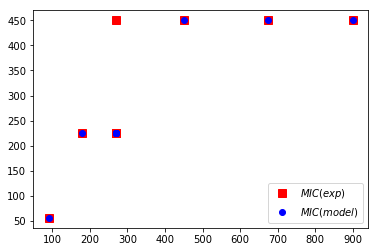

In [25]:

def lowpass(constants_prob,iptg, amp0):
    bg_bla=constants_prob[0]*5000     #20/0.1 #uM/min combo of beta and gamma
    laci=constants_prob[1]*50         #0.01 #uM combo of laci/kd_laci
    #kd_laci=constants_prob[2]*5e-3    #7.8e-4 #uM
    n_laci=constants_prob[2]*5        #2.5
    kd_iptg=constants_prob[3]*50      #25 #uM
    n_iptg=constants_prob[4]*5        #2
    #kcat=constants_prob[6]*5e6        #2.82e5 #1/m
    km=constants_prob[5]*500          #100 #uM
    ktr=constants_prob[6]*1e-2         #1e3 Combo of ktr and kcat
    MIC_int=constants_prob[7]*5       #amp[0,5]
    
    
    bla=np.zeros(len(iptg))
    for i in range(len(iptg)):
        D_iptg=1+(iptg[i]/kd_iptg)**n_iptg
        D_laci=1+(laci/(D_iptg))**n_laci
        bla[i]=bg_bla/D_laci

    
    amp=np.zeros((len(bla),len(amp0)))
    for i in range(len(bla)):
        for j in range(len(amp0)):
            coeff=[-ktr,(ktr*amp0[j]-ktr*km-bla[i]),ktr*amp0[j]*km]
            sol=np.roots(coeff)
            if sol[0]>=0 and sol[0]<amp0[j]:
                amp[i,j]=sol[0]
            else:
                amp[i,j]=sol[1]

    #amp=amp*349.41/1000 #convert to ug/ml
    return amp
amp=lowpass(constants_prob,iptg, amp0)
MIC_int=constants_prob[7]*5
MIC_mod=np.zeros(len(iptg))
for i in range(len(iptg)):
    for j in range(len(amp0)):
        if amp[i,j]>=MIC_int:
            break
        MIC_mod[i]=amp0[j]


plt.plot(iptg,MIC_exp,'ro',linewidth=2.0, label='$ MIC(exp) $',marker='s',markersize=8)
plt.plot(iptg,MIC_mod,'bo',linewidth=2.0, label='$ MIC(model) $')
plt.legend(loc='lower right');
#pd.DataFrame(np.concatenate((np.transpose([amp0]),np.transpose(amp)) , axis=1), 
#             columns=['$ amp \\ conc $',iptg[0],iptg[1],iptg[2],iptg[3],iptg[4],iptg[5],iptg[6],iptg[7]])

In [26]:
MIC_mod

array([  56.25,  225.  ,  225.  ,  450.  ,  450.  ,  450.  ,  225.  ,
        225.  ,  225.  ,  225.  ,  225.  ,  225.  ])

In [98]:

amp=lowpass(constants_prob,iptg, amp0)


kd_amp=0.01
n_amp=2
ampr=50
n_ampr=1
bg_tetc=500
k_tet=1

tetc=np.zeros((len(iptg),len(amp0)))
tet=np.zeros((len(iptg),len(amp0)))
for i in range(len(iptg)):
    for j in range(len(amp0)):
        D_amp=1+(amp[i,j]/kd_amp)**n_amp
        D_ampr=1+(ampr/(D_amp))**n_ampr
        tetc[i,j]=bg_tetc/D_ampr
        tet[i,j]=tet0[i]*k_tet/(k_tet+tetc[i,j])


MIC_tet_mod=np.zeros(len(iptg))[:,None]
for i in range(len(iptg)):
    for j in range(len(amp0)):
        if tet[i,j]<=0.9:
            break
        MIC_tet_mod[i]=amp0[j]
amp0new=np.insert(amp0,[0,0,0],[0,0,0])[None,:]
new=np.hstack((iptg,tet0,IND_exp,tet))
new=np.vstack((amp0new,new))
pd.DataFrame(data=new)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.000,0.001000,1.758000,3.516000,7.031000,14.063000,28.125000,56.250000,112.500000,225.000000,450.000000
1,90.0,18.0,1.758,1.666060,0.372405,0.135427,0.061988,0.042513,0.037576,0.036338,0.036030,0.035953,0.035934
2,180.0,18.0,3.516,1.666062,1.355805,0.876060,0.378334,0.137494,0.062550,0.042658,0.037612,0.036347,0.036032
3,270.0,18.0,7.031,1.666062,1.550292,1.284304,0.769241,0.312530,0.115141,0.056466,0.041105,0.037222,0.036250
4,450.0,18.0,7.031,1.666062,1.605768,1.448969,1.045672,0.507301,0.186382,0.076320,0.046207,0.038505,0.036571
5,675.0,18.0,7.031,1.666062,1.616012,1.482744,1.117851,0.574403,0.214858,0.084652,0.048377,0.039053,0.036708
6,900.0,18.0,7.031,1.666062,1.618616,1.491514,1.137704,0.594444,0.223821,0.087325,0.049077,0.039230,0.036752
7,270.0,4.5,0.000,0.416515,0.387573,0.321076,0.192310,0.078132,0.028785,0.014117,0.010276,0.009305,0.009062
8,270.0,9.0,0.000,0.833031,0.775146,0.642152,0.384620,0.156265,0.057571,0.028233,0.020552,0.018611,0.018125
9,270.0,13.5,3.516,1.249546,1.162719,0.963228,0.576931,0.234397,0.086356,0.042350,0.030828,0.027916,0.027187


In [99]:
highpass=np.hstack((IND_exp,MIC_tet_mod))
pd.DataFrame(data=highpass)

,0,1
0,1.758,0.001
1,3.516,1.758
2,7.031,3.516
3,7.031,7.031
4,7.031,7.031
5,7.031,7.031
6,0.000,0.000
7,0.000,0.000
8,3.516,3.516
9,7.031,3.516


In [46]:

amp=lowpass(constants_prob,iptg, amp0)
amp0new=np.insert(amp0,[0,0,0],[0,0,0])[None,:]
new=np.hstack((iptg,tet0,MIC_exp,amp))
new=np.vstack((amp0new,new))
pd.DataFrame(data=new)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.00,0.001000,1.758000,3.516000,7.031000,14.063000,28.125000,56.250000,112.500000,225.000000,450.000000
1,90.0,18.0,56.25,0.000012,0.020563,0.041132,0.082278,0.164668,0.329726,0.661061,1.328606,2.683531,5.475489
2,180.0,18.0,225.00,0.000003,0.005085,0.010169,0.020338,0.040684,0.081390,0.162879,0.326153,0.653896,1.314193
3,270.0,18.0,225.00,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
4,450.0,18.0,450.00,0.000001,0.002055,0.004111,0.008220,0.016443,0.032888,0.065792,0.131649,0.263558,0.528155
5,675.0,18.0,450.00,0.000001,0.001866,0.003733,0.007465,0.014932,0.029866,0.059746,0.119545,0.239303,0.479463
6,900.0,18.0,450.00,0.000001,0.001816,0.003632,0.007262,0.014526,0.029055,0.058123,0.116296,0.232793,0.466397
7,270.0,4.5,225.00,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
8,270.0,9.0,450.00,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
9,270.0,13.5,225.00,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336


In [ ]:
plt.semilogx(amp0,amp[0],color='r',linewidth=2.0, label='IPTG= $ 0 \mu M $', basex=2)
plt.semilogx(amp0,amp[1],color='b',linewidth=2.0, label='IPTG= $ 300 \mu M $', basex=2)
plt.xlabel('amp0')
plt.ylabel('amp')
plt.legend(loc='upper left')
plt.grid(True)

In [ ]:
import plotly 
plotly.tools.set_credentials_file(username='kadamkaustubh5753', api_key='9WKnfnb9ChfOTQJ2GfQc')
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

# Read data from a csv
z_data = final_amp

data = [
    go.Surface(
        x=iptg,
        y=np.log2(amp0),
        z=z_data,
        surfacecolor=z_data
    )
]
layout = go.Layout(
    title='Amp Steady state',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
exp=np.array([[16,0.3],[32,5],[64,10],[128, 20],[256 ,30],[512 , 50],[1024 , 75],[2048 , 300]],dtype=int)

In [90]:
IND_exp.shape

(12, 1)

In [ ]:
amp0new

In [91]:
MIC_tet_mod.shape

(12, 1)

In [ ]:
x=amp.flatten()
x

In [39]:
pd.DataFrame(data=amp)

,0,1,2,3,4,5,6,7,8,9
0,0.000012,0.020563,0.041132,0.082278,0.164668,0.329726,0.661061,1.328606,2.683531,5.475489
1,0.000003,0.005085,0.010169,0.020338,0.040684,0.081390,0.162879,0.326153,0.653896,1.314193
2,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
3,0.000001,0.002055,0.004111,0.008220,0.016443,0.032888,0.065792,0.131649,0.263558,0.528155
4,0.000001,0.001866,0.003733,0.007465,0.014932,0.029866,0.059746,0.119545,0.239303,0.479463
5,0.000001,0.001816,0.003632,0.007262,0.014526,0.029055,0.058123,0.116296,0.232793,0.466397
6,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
7,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
8,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336
9,0.000002,0.002900,0.005799,0.011598,0.023199,0.046404,0.092840,0.185808,0.372132,0.746336


In [40]:
pd.DataFrame(data=tet)

,0,1,2,3,4,5,6,7,8,9
0,3.963205,2.992383,2.436560,1.824744,1.288765,0.905713,0.669861,0.537746,0.467634,0.431491
1,3.963776,3.661787,3.406780,3.000162,2.446126,1.834051,1.296099,0.910490,0.672629,0.539238
2,3.963857,3.785130,3.623361,3.342171,2.904820,2.330435,1.722645,1.210379,0.855106,0.640720
3,3.963888,3.835328,3.715641,3.499680,3.142231,2.628078,2.019814,1.446732,1.011594,0.732273
4,3.963895,3.846757,3.737003,3.537232,3.201596,2.707603,2.105417,1.519618,1.062333,0.762908
5,3.963897,3.849838,3.742784,3.547468,3.217972,2.729926,2.129956,1.540937,1.077407,0.772102
6,3.963857,3.785130,3.623361,3.342171,2.904820,2.330435,1.722645,1.210379,0.855106,0.640720
7,3.963857,3.785130,3.623361,3.342171,2.904820,2.330435,1.722645,1.210379,0.855106,0.640720
8,3.963857,3.785130,3.623361,3.342171,2.904820,2.330435,1.722645,1.210379,0.855106,0.640720
9,3.963857,3.785130,3.623361,3.342171,2.904820,2.330435,1.722645,1.210379,0.855106,0.640720
